# Ранее мы пытались выяснить, повлияла ли новостная лента на поведение тестовых и контрольных пользователей. В прошлый раз мы просто вычислили средние значения. Но знаем ли мы что-то о дисперсиях? А что, если она тоже изменилась? А что, если у нас были выбросы?

## Чтобы ответить на эти вопросы, может быть полезно нарисовать диаграмму «ящик-корпус».

In [85]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt


conn = sqlite3.connect('../data/checking-logs.sqlite')

def ab_query(table_name, connection):
    query = f"""
    WITH user_visits AS (
        SELECT 
            t.uid AS uid,
            DATETIME(t.first_view_ts) AS first_view
        FROM 
            {table_name} t
        JOIN 
            deadlines d ON t.labname = d.labs
        WHERE 
            d.labs != 'project1'
    ),
    averages AS (
        SELECT
            CASE 
                WHEN DATETIME(t.first_commit_ts) < uv.first_view THEN 'before'
                ELSE 'after'
            END AS time,
            t.uid,
            AVG(JULIANDAY(DATETIME(t.first_commit_ts)) - JULIANDAY(DATETIME(d.deadlines, 'unixepoch'))) * 24 AS avg_diff
        FROM 
            {table_name} t
        JOIN 
            deadlines d ON t.labname = d.labs
        JOIN 
            user_visits uv ON t.uid = uv.uid
        WHERE 
            d.labs != 'project1'
        GROUP BY 
            t.uid, time
    ),
    users_with_both AS (
        SELECT
            uid
        FROM
            averages
        GROUP BY
            uid
        HAVING
            COUNT(DISTINCT time) = 2
    )
    SELECT 
        time, 
        uid,
        AVG(avg_diff) AS avg_diff
    FROM 
        averages
    WHERE 
        uid IN (SELECT uid FROM users_with_both)
    GROUP BY 
        time, uid;
    """
    return pd.read_sql_query(query, connection)

In [86]:
test_results = ab_query("test", conn)
control_results = ab_query("control", conn)

test_results.head()

,time,uid,avg_diff
0,after,user_1,-103.969167
1,after,user_18,-10.973611
2,after,user_19,-82.948519
3,after,user_21,-79.200556
4,after,user_25,-128.414583


In [87]:
control_results.head()

,time,uid,avg_diff
0,after,user_12,-75.322500
1,after,user_13,-81.901389
2,after,user_15,-32.529722
3,after,user_16,17.564861
4,after,user_2,-94.608426


In [88]:
def create_boxplot(ax, control_data, test_data, title):
    # Диаграмма
    box = ax.boxplot(
        [control_data, test_data],
        labels=['control', 'test'],
        boxprops=dict(linewidth=3, color='green'),  # Цвет боксов
        whiskerprops=dict(linewidth=1, color='red'),  # Цвет усов
        capprops=dict(color='red'),  # Цвет границ (усов)
        medianprops=dict(linewidth=2, color='red'),  # Цвет медианы
        meanprops=dict(marker='^', markerfacecolor='green', markersize=3, label='Mean')  # Среднее
    )
    
    # Отображение среднего
    mean_control = control_data.mean()
    mean_test = test_data.mean()
    ax.plot([1], [mean_control], marker='^', color='green', markersize=3)  # среднее для контрольной группы
    ax.plot([2], [mean_test], marker='^', color='green', markersize=3)  # среднее для тестовой группы
    
    # Добавление вертикальных линий
    for i, line in enumerate(box['whiskers']):
        x, y = line.get_xdata(), line.get_ydata()
        if y[0] == y[1]:  # Если усы отсутствуют (имеют одинаковую высоту)
            ax.axvline(x=x[0], color='lightgrey', linestyle='--', linewidth=1)
            
    # Настройки графика
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('[group]', fontsize=10)
    ax.grid(True)

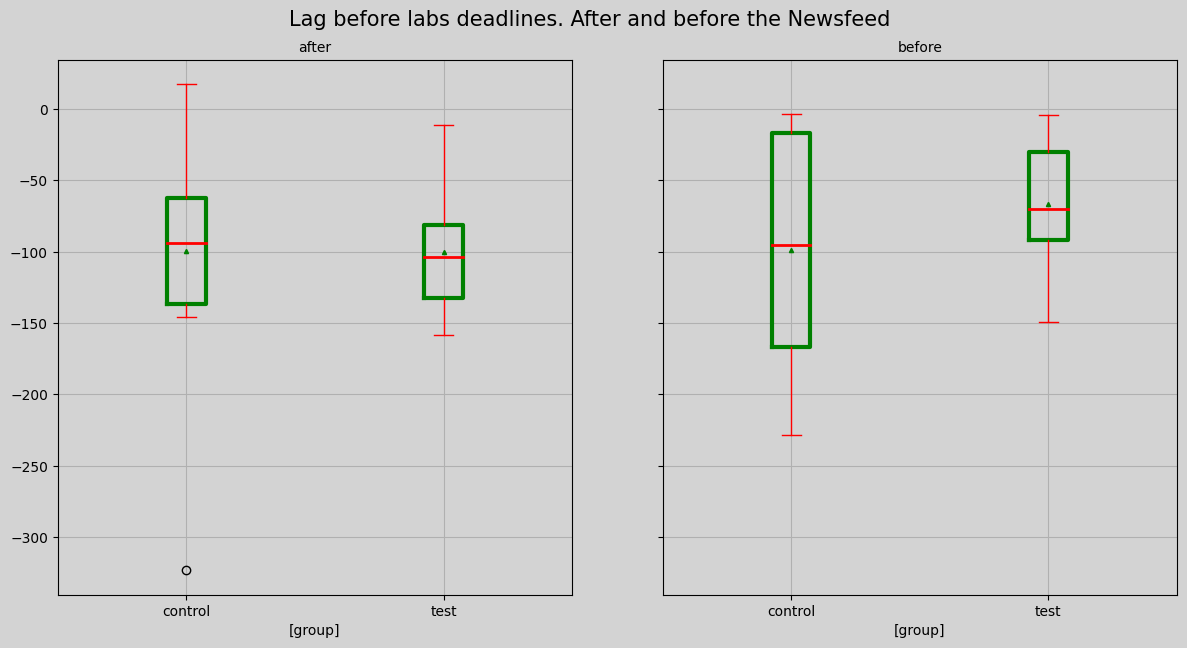

In [89]:
# Создание графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.patch.set_facecolor('lightgrey')
for ax in axes:
    ax.set_facecolor('lightgrey')
axes[0].set_position([0.1, 0.2, 0.45, 0.5])  # Первый график
axes[1].set_position([0.57, 0.2, 0.45, 0.5])  # Второй график (начало ближе к первому)

# Данные для графиков
control_after = control_results[control_results.time == 'after']['avg_diff']
test_after = test_results[test_results.time == 'after']['avg_diff']
control_before = control_results[control_results.time == 'before']['avg_diff']
test_before = test_results[test_results.time == 'before']['avg_diff']

# Создание boxplot для "after" и "before"
create_boxplot(axes[0], control_after, test_after, 'after')
create_boxplot(axes[1], control_before, test_before, 'before')

# Общий заголовок
fig.suptitle('Lag before labs deadlines. After and before the Newsfeed', fontsize=15, x=0.45, y=1)
plt.tight_layout()
plt.show()

### Каков был IQR контрольной группы до появления новостей?

**Ответ: 150**

In [90]:
conn.close()